In [1]:
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, log_loss
SEED = 42

In [2]:
df = pd.read_csv('../raw_data/people_analytics.csv')    # 1470 rows x 35 columns
df.shape

(1470, 35)

In [3]:
# data overview
print('Rows x Columns : ', df.shape[0], 'x', df.shape[1])
print('Features: ', df.columns.tolist())
print('\nUnique values:')
print(df.nunique())
for col in df.columns:
    print(col, ':', sorted(df[col].unique()))


Rows x Columns :  1470 x 35
Features:  ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Unique values:
Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1

In [4]:
# type of data, how many missing values/null fields
df.info()
print('\nMissing values:  ', df.isnull().sum().values.sum())
df.isnull().sum()
# note: there is no missing data, dataset is quite clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [5]:
# # proportion of Attrition, class is imbalance
# print(df.Attrition.value_counts())
# print(df.Attrition.value_counts(normalize=True))
# df['Attrition'].value_counts().plot('bar', color=('C0','C1')).set_title('Attrition')

20.704225352112676
4.146589863793163


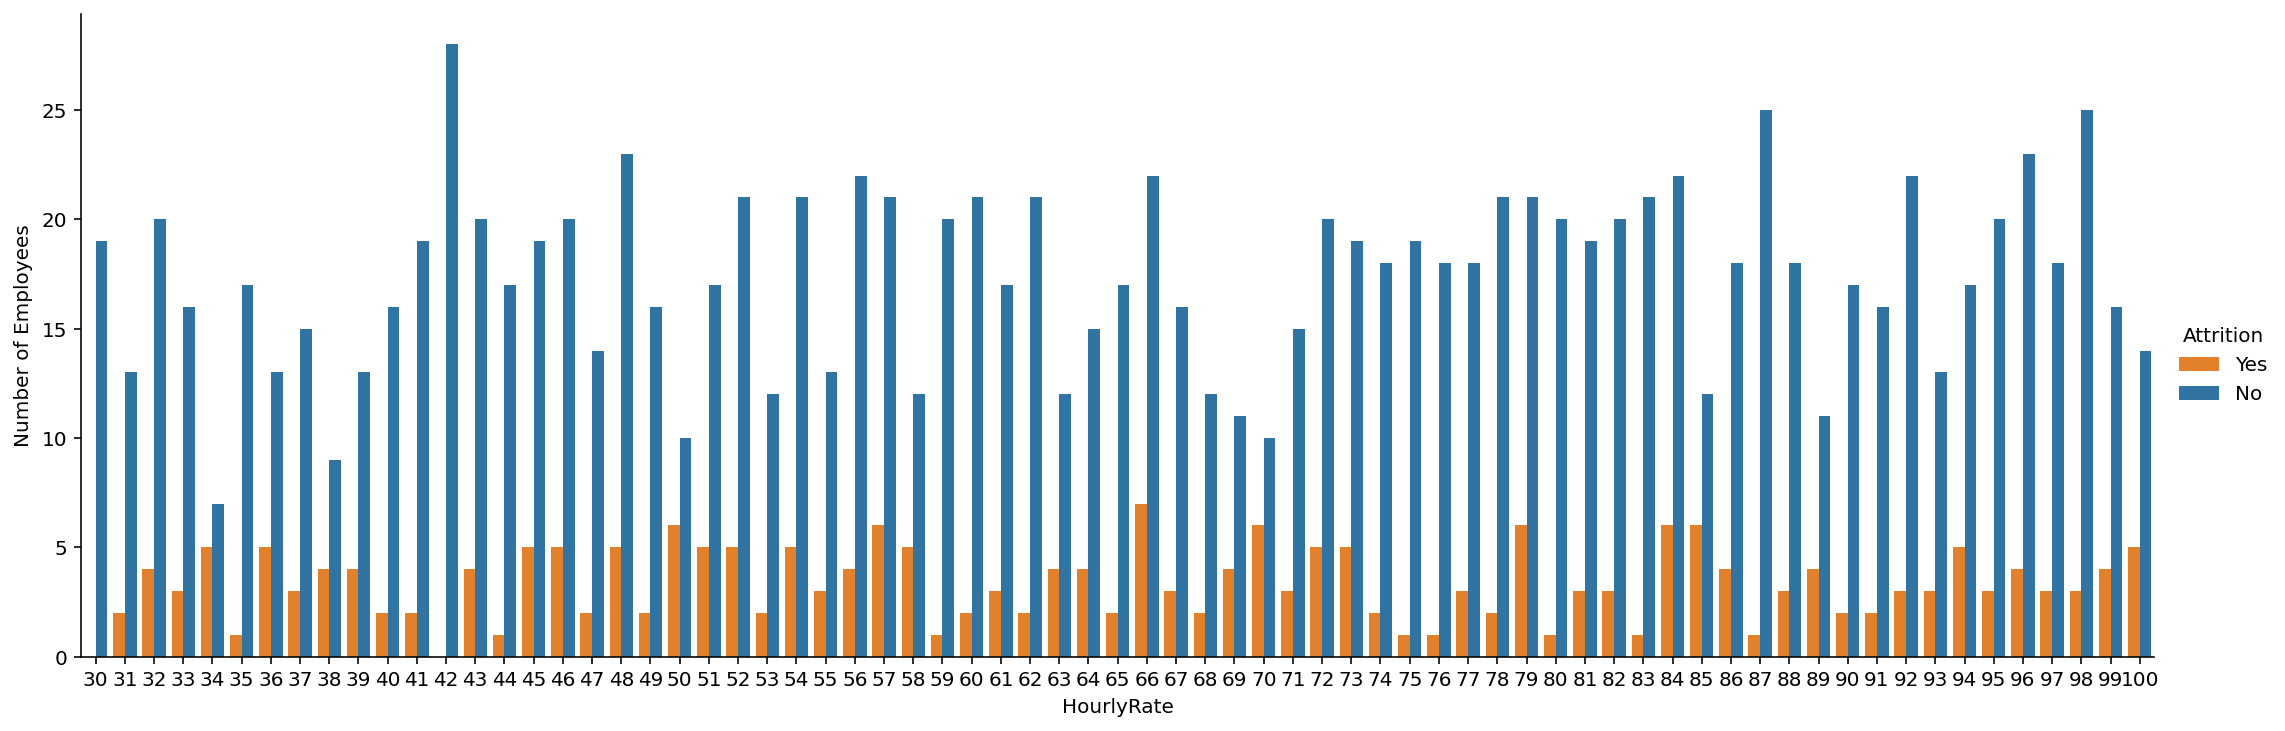

In [6]:
# to plot employee distribution by HourlyRate, with distinct Attrition classes
# Average count of 20 employees in each HourlyRate class from 30 to 100
print(df.HourlyRate.value_counts().mean())
print(np.std(df.HourlyRate.value_counts()))
sns.axes_style('whitegrid')
sns.catplot('HourlyRate', data=df, aspect=3, kind='count', hue='Attrition', palette=['C1', 'C0']).set_ylabels('Number of Employees')

In [7]:
print(df.HourlyRate.mean())
print(np.std(df.HourlyRate))

65.89115646258503
20.322511646324017


In [8]:
print(df[df.Attrition=='No']['HourlyRate'].mean())
print(np.std(df[df.Attrition=='No']['HourlyRate']))

65.9521492295215
20.372487864867416


In [9]:
print(df[df.Attrition=='Yes']['HourlyRate'].mean())
print(np.std(df[df.Attrition=='Yes']['HourlyRate']))

65.57383966244726
20.057507807158085


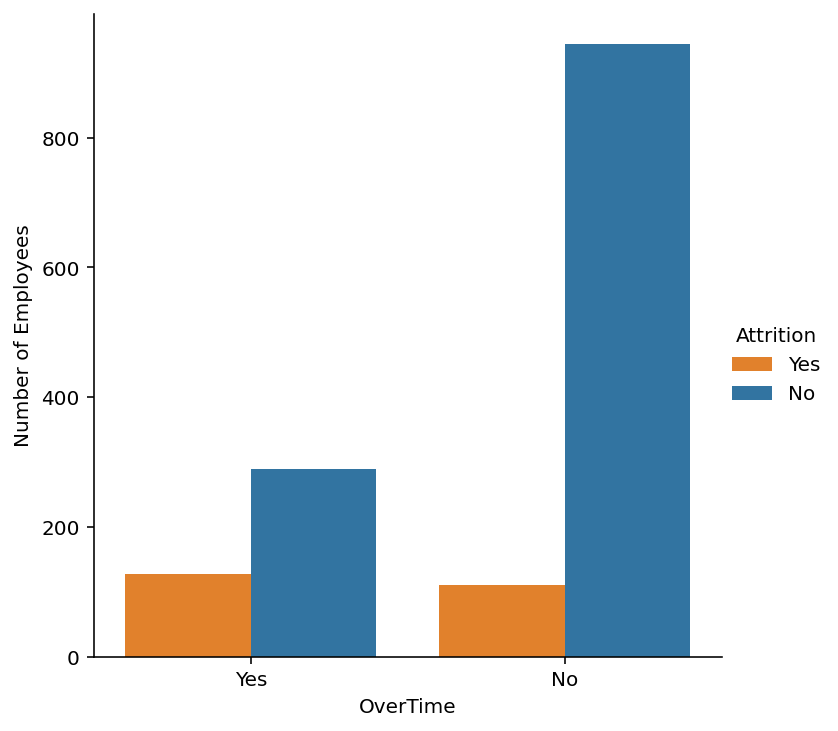

In [10]:
# to plot employee distribution by OverTime, with distinct Attrition classes
sns.axes_style('whitegrid')
sns.factorplot("OverTime", data=df, aspect=1, kind='count', hue='Attrition', palette=['C1', 'C0']).set_ylabels('Number of Employees')

In [11]:
df.EducationField.value_counts()

Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: EducationField, dtype: int64

In [12]:
# to analyse JobRole in each Department
for dpmt in df['Department'].unique():
    print('\n', dpmt, ':')
    print(df[df['Department']==dpmt]['JobRole'].value_counts())


 Sales :
Sales Executive         326
Sales Representative     83
Manager                  37
Name: JobRole, dtype: int64

 Research & Development :
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Research Director             80
Manager                       54
Name: JobRole, dtype: int64

 Human Resources :
Human Resources    52
Manager            11
Name: JobRole, dtype: int64


In [13]:

# to create new feature whether JobRole is related to EducationField, 0 = not related, 1 = related, 2 = somewhat related
# HR seems to have done fabulously in job matching as this feature did not emerge useful
df['EduField_Dept'] = 0
for i, row in df.iterrows():
    if row['EducationField']=='Human Resources' and row['Department']=='Human Resources':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Life Sciences' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 2
    elif row['EducationField']=='Life Sciences' and row['Department']=='Research & Development':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Medical' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 2
    elif row['EducationField']=='Medical' and row['Department']=='Research & Development':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Technical Degree' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 2
    elif row['EducationField']=='Technical Degree' and row['Department']=='Research & Development':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Marketing' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 1
        
# for index, row in df.iterrows():
#     print(row['EducationField'], '->', row['Department'], '=>', row['EduField_Dept'])


In [14]:
# to define new features (divide by something+1 to prevent division by zero)
df['Job_Coy'] = df['JobLevel'] / (df['YearsAtCompany'] + 1)
df['Edu_Age_TotalWorking'] = df['Education'] / (df['Age'] + df['TotalWorkingYears'])
df['CurrMgr_Coy'] = df['YearsWithCurrManager'] / (df['YearsAtCompany'] + 1)
df['CurrRole_CurrMgr'] = df['YearsInCurrentRole'] / (df['YearsWithCurrManager'] + 1)
# df

In [15]:
# to check for categorical type columns and each unique values
for col in df.select_dtypes(['object']).columns:
    print(col, ':', sorted(df[col].unique()))

Attrition : ['No', 'Yes']
BusinessTravel : ['Non-Travel', 'Travel_Frequently', 'Travel_Rarely']
Department : ['Human Resources', 'Research & Development', 'Sales']
EducationField : ['Human Resources', 'Life Sciences', 'Marketing', 'Medical', 'Other', 'Technical Degree']
Gender : ['Female', 'Male']
JobRole : ['Healthcare Representative', 'Human Resources', 'Laboratory Technician', 'Manager', 'Manufacturing Director', 'Research Director', 'Research Scientist', 'Sales Executive', 'Sales Representative']
MaritalStatus : ['Divorced', 'Married', 'Single']
Over18 : ['Y']
OverTime : ['No', 'Yes']


In [16]:
# to drop useless features
df = df.drop(columns=['Over18', 'EmployeeCount', 'EmployeeNumber', 'StandardHours'])

# label encoding to clean up categorical data
categorical_data = {
    'Attrition': {'No':0, 'Yes':1}, 
    'BusinessTravel': {'Non-Travel':0, 'Travel_Frequently':1, 'Travel_Rarely':2}, 
    'Department': {'Human Resources':0, 'Research & Development':1, 'Sales':2}, 
    'EducationField': {'Human Resources':0, 'Life Sciences':1, 'Marketing':2, 'Medical':3, 'Technical Degree':4, 'Other':5}, 
    'Gender': {'Female':0, 'Male':0}, 
    'JobRole': {'Healthcare Representative':0, 'Human Resources':1, 'Laboratory Technician':2, 'Manager':3, 'Manufacturing Director':4, 'Research Director':5, 'Research Scientist':6, 'Sales Executive':7, 'Sales Representative':8}, 
    'MaritalStatus': {'Divorced':0, 'Single':1, 'Married':2}, 
    #'Over18': {'Y':1}, 
    'OverTime': {'No':0, 'Yes':1}    }
df = df.replace(categorical_data)
df


Age  Attrition  BusinessTravel  DailyRate  Department  DistanceFromHome  \
0      41          1               2       1102           2                 1   
1      49          0               1        279           1                 8   
2      37          1               2       1373           1                 2   
3      33          0               1       1392           1                 3   
4      27          0               2        591           1                 2   
...   ...        ...             ...        ...         ...               ...   
1465   36          0               1        884           1                23   
1466   39          0               2        613           1                 6   
1467   27          0               2        155           1                 4   
1468   49          0               1       1023           2                 2   
1469   34          0               2        628           1                 8   

      Education  EducationField  EnvironmentSatisfaction  Gender  ...  \
0             2               1                        2       0  ...   
1             1               1                        3       0  ...   
2             2               5                        4       0  ...   
3             4               1                        4       0  ...   
4             1               3                        1       0  ...   
...         ...             ...                      ...     ...  ...   
1465          2               3                        3       0  ...   
1466          1               3                        4       0  ...   
1467          3               1                        2       0  ...   
1468          3               3                        4       0  ...   
1469          3               3                        2       0  ...   

      WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
0                   1               6                   4   
1                   3              10                   7   
2                   3               0                   0   
3                   3               8                   7   
4                   3               2                   2   
...               ...             ...                 ...   
1465                3               5                   2   
1466                3               7                   7   
1467                3               6                   2   
1468                2               9                   6   
1469                4               4                   3   

      YearsSinceLastPromotion  YearsWithCurrManager  EduField_Dept   Job_Coy  \
0                           0                     5              2  0.285714   
1                           1                     7              1  0.181818   
2                           0                     0              0  1.000000   
3                           3                     0              1  0.111111   
4                           2                     2              1  0.333333   
...                       ...                   ...            ...       ...   
1465                        0                     3              1  0.333333   
1466                        1                     7              1  0.375000   
1467                        0                     3              1  0.285714   
1468                        0                     8              2  0.200000   
1469                        1                     2              1  0.400000   

      Edu_Age_TotalWorking  CurrMgr_Coy  CurrRole_CurrMgr  
0                 0.040816     0.714286          0.666667  
1                 0.016949     0.636364          0.875000  
2                 0.045455     0.000000          0.000000  
3                 0.097561     0.000000          7.000000  
4                 0.030303     0.666667          0.666667  
...                    ...          ...               ...  
1465              0.037736     0.500000   

Top 10 Features: ['OverTime', 'MonthlyIncome', 'TotalWorkingYears', 'Age', 'StockOptionLevel', 'YearsAtCompany', 'Edu_Age_TotalWorking', 'JobLevel', 'YearsWithCurrManager', 'CurrMgr_Coy']


(11.5, -0.5)

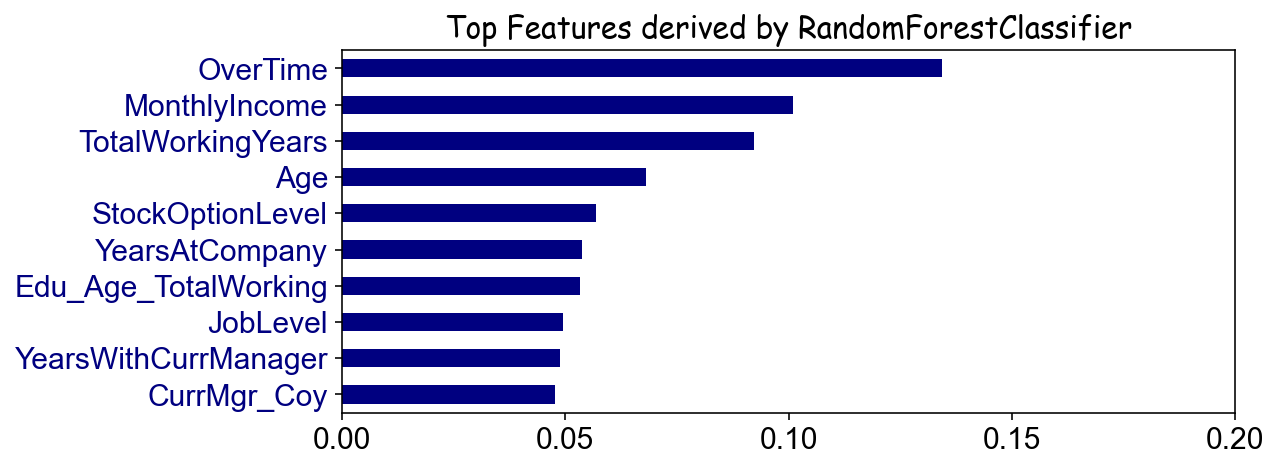

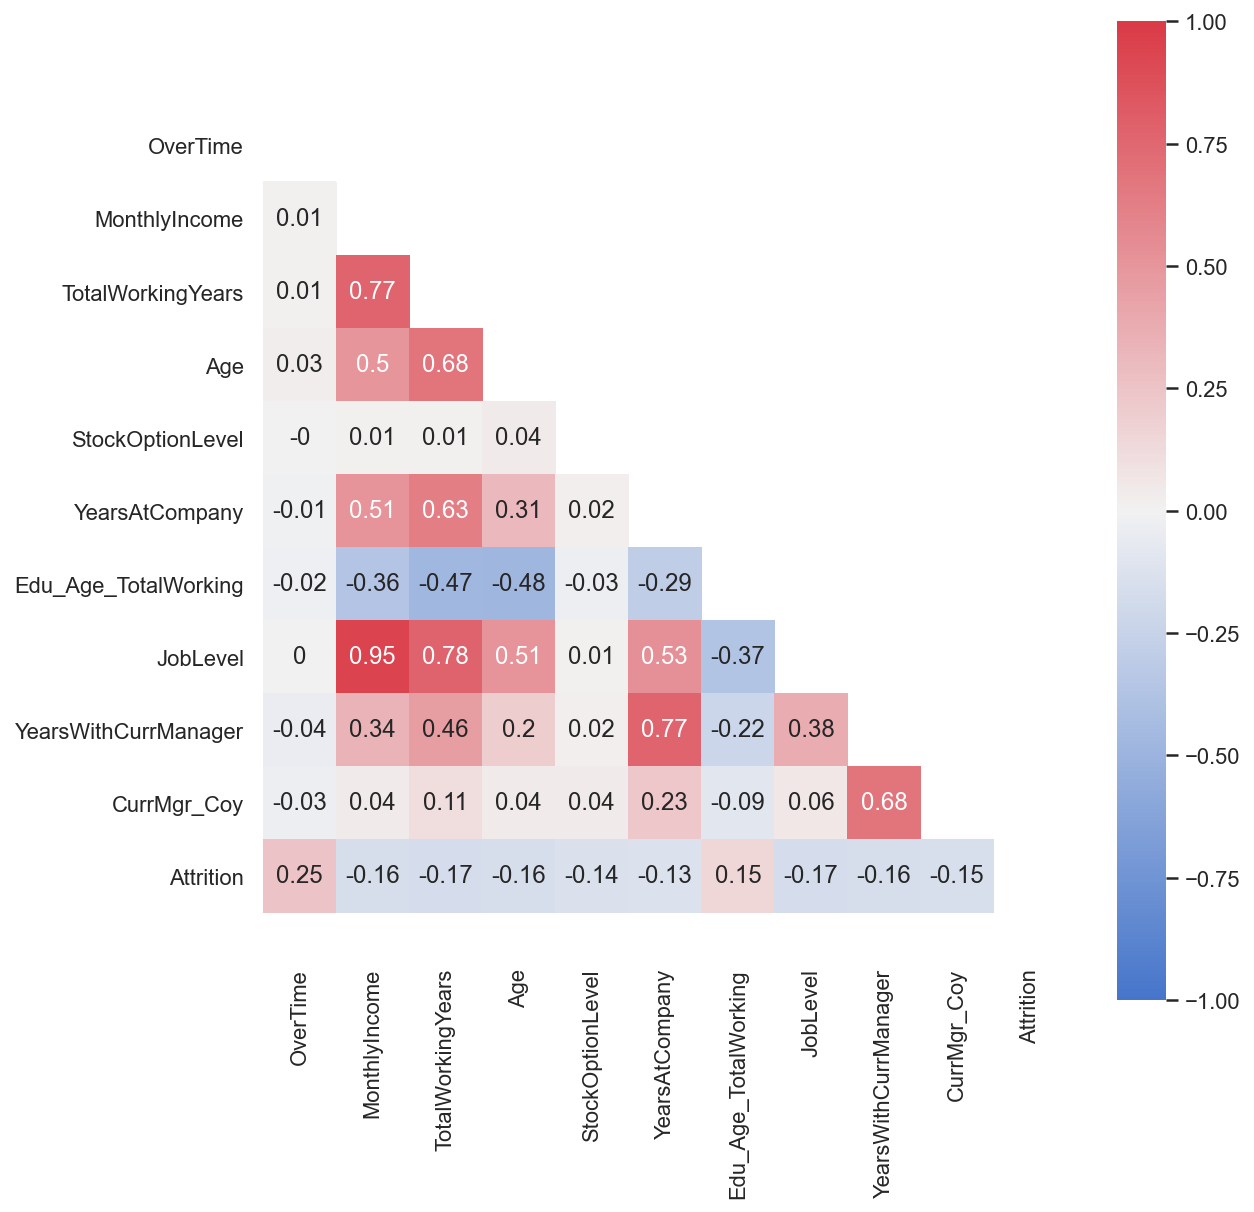

In [17]:
# define feature X and target y dataset (X and y are commonly used in sklearn)
X, y = df.drop('Attrition', axis=1), df['Attrition']

# use RandomForestClassifier to look for important key features
n = 10    # specify n (top n features)
rfc = RandomForestClassifier(random_state=SEED, n_estimators=200, max_depth=3)
rfc_model = rfc.fit(X, y)
pd.Series(rfc_model.feature_importances_, index=X.columns).nlargest(n).plot(kind='barh', 
    figsize=[8, n/3], color='navy').invert_yaxis()    # most important feature is on top, ie, descending order
ticks_x = np.linspace(0, 0.2, 5)   # (start, end, number of ticks)
plt.xticks(ticks_x, fontsize=15, color='black')
plt.yticks(size=15, color='navy' )
plt.title('Top Features derived by RandomForestClassifier', family='fantasy', size=15)
top10_features = pd.Series(rfc_model.feature_importances_, index=X.columns).nlargest(10)
print('Top 10 Features:', list(top10_features.index))

# check for correlation between top 10 features
X = df.loc[:, top10_features.index]
y = df['Attrition']
df_top10 = X.join(y)
# correlation matrix heatmap visualization
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(df_top10.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(9,9))
# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Red=10, Green=128, Blue=255
# Plot the heatmap
sns.heatmap(df_top10.corr().round(2), mask=mask, annot=True, annot_kws={"size": 12}, square=True, 
            cmap=cmap , vmin=-1, vmax=1, ax=ax)  # annot=True display corr label
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)


In [18]:
# drop highly correlated features: JobLevel & MonthlyIncome = 0.95 (JobLevel has lower feature importance)
df = df.drop(columns=['JobLevel'])

In [19]:
# re-run correlation matrix heatmap: TotalWorkingYears & MonthlyIncome = 0.77, YearsWithCurrManager & YearsAtCompany = 0.77
df = df.drop(columns=['TotalWorkingYears', 'YearsWithCurrManager'])

In [20]:
# re-run correlation matrix heatmap: YearsInCurrentRole & YearsAtCompany = 0.76
df = df.drop(columns=['YearsInCurrentRole'])

In [21]:
# re-run correlation matrix heatmap: YearsAtCompany & MonthlyIncome = 0.51
df = df.drop(columns=['YearsAtCompany'])

In [22]:
# re-run correlation matrix heatmap: Age & MonthlyIncome = 0.5
df = df.drop(columns=['Age'])

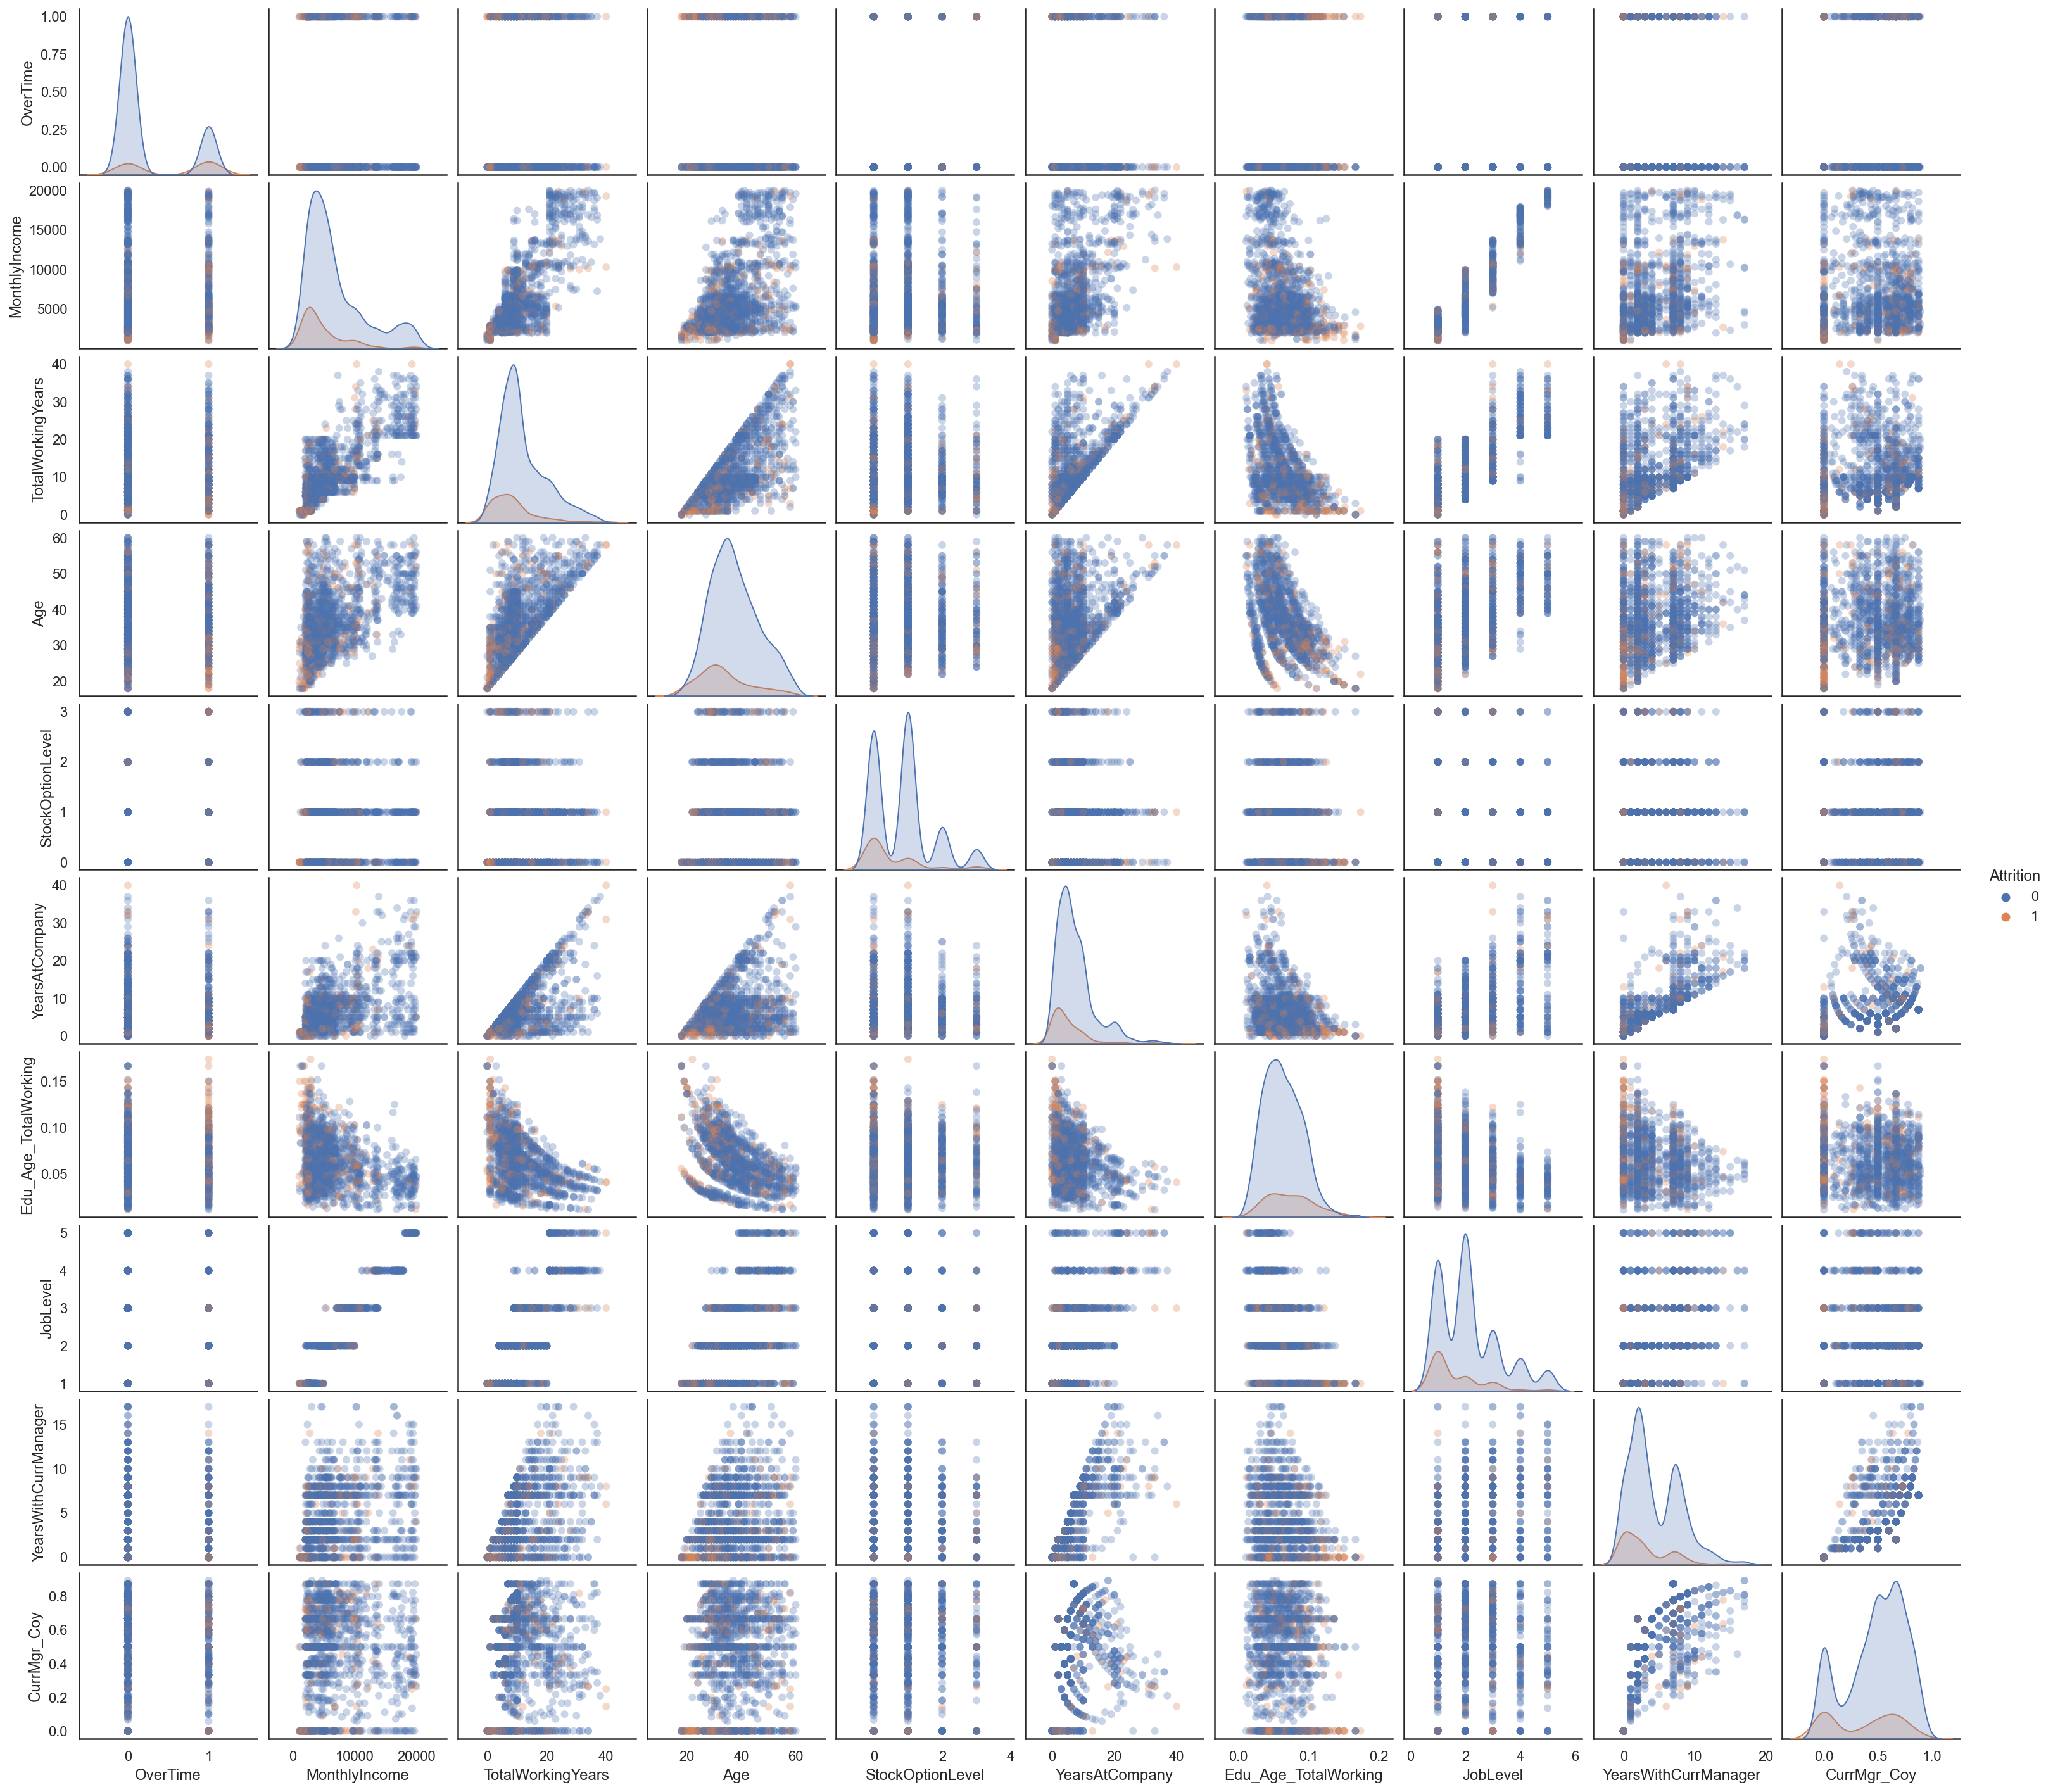

In [23]:
# to visualise pair plot of top 10 features
sns.pairplot(df_top10, hue='Attrition', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1)

In [24]:
# # analyse feature-outcome distribution in visualisation
# features = list(top10_features.index)[0:8]   # visualise only the top 8 features

# ROWS, COLS = 2, 4
# fig, ax = plt.subplots(ROWS, COLS, figsize=(18,8) )
# row, col = 0, 0
# for i, feature in enumerate(features):
#     if col == COLS - 1:
#         row += 1
#     col = i % COLS
    
# #     df[feature].hist(bins=35, color='green', alpha=0.5, ax=ax[row, col]).set_title(feature)  #show all, comment off below 2 lines
#     df[df.Attrition==0][feature].hist(bins=35, color='blue', alpha=0.5, ax=ax[row, col]).set_title(feature)
#     df[df.Attrition==1][feature].hist(bins=35, color='orange', alpha=0.7, ax=ax[row, col])
    
# plt.legend(['No Attrition', 'Attrition'])
# fig.subplots_adjust(hspace=0.3)

In [25]:
# define feature X and target y dataset (X and y are commonly used in sklearn)
X, y = df.drop('Attrition', axis=1), df['Attrition']
print('X', X.shape, 'y', y.shape)

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED, stratify=y)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

# kf = KFold(n_splits=5, shuffle=True, random_state=SEED)   # this may result in imbalance classes in each fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)   # use this

X (1470, 29) y (1470,)
X_train (1176, 29)
y_train (1176,)
X_test (294, 29)
y_test (294,)


In [26]:
# # To explore: Scaling Numerical columns
# from sklearn.preprocessing import MinMaxScaler, StandardScaler   # not much difference in results
# # scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range = (0,1))
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [27]:
## BASELINE model performance evaluation
# to define which metric and model to use
met = {'accuracy':True, 'precision':True, 'recall':True, 'f1score':True, 'rocauc':True, 'logloss':True}
mod = {'gnb':True, 'bnb':True, 'mnb':True, 'logr':True, 'knn':True, 'dt':True, 'rf':True, 'xgb':False, 'svc':True, 'lsvc':True}

# to give model baseline performance report in dataframe 
def metric(model, X_train, X_test, y_train, y_test, name):
    accuracy1 = accuracy2 = precision = recall = f1score = rocauc = logloss = 0.0
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if met['accuracy']:
        accuracy1 = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
        accuracy2 = accuracy_score(y_test, y_pred)
    if met['precision']: precision = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='precision'))
    if met['recall']:    recall    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='recall'))
    if met['f1score']:   f1score   = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='f1'))
    if met['rocauc']:    rocauc    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc'))
    if met['logloss']:   logloss   = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    return pd.DataFrame({'model'    : [name],
                         'accuracy' : [accuracy1],
                         'acc(test)': [accuracy2],
                         'precision': [precision],
                         'recall'   : [recall],
                         'f1score'  : [f1score],
                         'rocauc'   : [rocauc],
                         'logloss'  : [logloss],
                         'timetaken': [0.0]       })   # timetaken: to be used for comparison later

# to initialise an empty dataframe
rpt = pd.DataFrame({'model'    : [],
                    'accuracy' : [],
                    'acc(test)': [],
                    'precision': [],
                    'recall'   : [],
                    'f1score'  : [],
                    'rocauc'   : [],
                    'logloss'  : [],
                    'timetaken': []       })

# to initialise all baseline models
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
logr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
svc = SVC()
lsvc = LinearSVC()

if mod['gnb']:  rpt = pd.concat([rpt, metric(gnb, X_train, X_test, y_train, y_test, 'GaussianNB')])   # default axis=0
if mod['bnb']:  rpt = pd.concat([rpt, metric(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB')])
if mod['mnb']:  rpt = pd.concat([rpt, metric(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB')])
if mod['logr']: rpt = pd.concat([rpt, metric(logr, X_train, X_test, y_train, y_test, 'LogisticRegression')])
if mod['knn']:  rpt = pd.concat([rpt, metric(knn, X_train, X_test, y_train, y_test, 'KNearestNeighbour')])
if mod['dt']:   rpt = pd.concat([rpt, metric(dt, X_train, X_test, y_train, y_test, 'DecisionTree')])
if mod['rf']:   rpt = pd.concat([rpt, metric(rf, X_train, X_test, y_train, y_test, 'RandomForest')])
if mod['xgb']:  rpt = pd.concat([rpt, metric(xgb, X_train, X_test, y_train, y_test, 'XGBoost')])
if mod['svc']:  rpt = pd.concat([rpt, metric(svc, X_train, X_test, y_train, y_test, 'SVC')])
if mod['lsvc']: rpt = pd.concat([rpt, metric(lsvc, X_train, X_test, y_train, y_test, 'LinearSVC')])
rpt = rpt.reset_index(drop=True)
display(rpt)

## TUNED model performance evaluation
def tuning(model, X_train, X_test, y_train, y_test, name):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                   np.linspace(optimal_th-0.1,    optimal_th+0.1,    21), 
                   np.linspace(optimal_th-0.01,   optimal_th+0.01,   21)]
        for th in th_list[i]:
            if th<0: 
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display f1score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print('\n', name, 'accuracy score is')
    accuracy1 = model.score(X_train, y_train)   # .score uses accuracy
    print('Training: {:.2f}%'.format(100*accuracy1))
    accuracy2 = model.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy2))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('Default threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('Adjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
#     y_pred = [1 if x==True else 0 if x==False else x for x in y_pred]   # .predict->0/1; .predict_proba->False/True
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = model.predict_proba(X_test)[:,1]   # use this at optimal th, for AUC and logloss
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    print(name, 'AUC: {:.4f}'.format(rocauc))
    logloss      = log_loss(y_test, y_pred)   # same result using y_pred = model.predict_proba(X_test)
    print(name, 'Log-loss: {:.4f}'.format(logloss))

    return pd.DataFrame({'model'    : [name],
                         'accuracy' : [accuracy1],
                         'acc(test)': [accuracy2],
                         'precision': [precision],
                         'recall'   : [recall],
                         'f1score'  : [f1score],
                         'rocauc'   : [rocauc],
                         'logloss'  : [logloss],
                         'timetaken': [1000]       })   # timetaken: to be used for comparison late

# to initialise an empty dataframe
tuned = pd.DataFrame({'model'    : [],
                    'accuracy' : [],
                    'acc(test)': [],
                    'precision': [],
                    'recall'   : [],
                    'f1score'  : [],
                    'rocauc'   : [],
                    'logloss'  : [],
                    'timetaken': []       })

if mod['gnb']:
    print('\n"""""" GaussianNB """"""')
    time1 = time.time()
    gnb = GaussianNB()
    model_tuned = tuning(gnb, X_train, X_test, y_train, y_test, 'GaussianNB')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0

if mod['bnb']:
    print('\n"""""" BernoulliNB """"""')
    time1 = time.time()
    bnb = BernoulliNB()
    model_tuned = tuning(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0

if mod['mnb']:
    print('\n"""""" MultinomialNB """"""')
    time1 = time.time()
    mnb = MultinomialNB()
    model_tuned = tuning(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0

if mod['logr']:
    print('\n"""""" LogisticRegression """"""')
    time1 = time.time()
    print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold CV on train data')
    score_list = []
    c_list = 10**np.linspace(-3,3,200)
    for c in c_list:
        logr = LogisticRegression(C = c)
        cvs = (cross_val_score(logr, X_train, y_train, cv=kf, scoring='f1')).mean()
        score_list.append(cvs)
        print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
    print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
    optimal_c = float(c_list[score_list.index(max(score_list))])
    print('optimal value of C = {:.3f}'.format(optimal_c))
    logr = LogisticRegression(C = optimal_c)
    model_tuned = tuning(logr, X_train, X_test, y_train, y_test, 'LogisticRegression')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    
if mod['knn']:
    print('\n"""""" KNN """""" ')
    time1 = time.time()
    print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold CV on train data')
    k_scores = []
    for k in range(1, 21):
        knn = KNeighborsClassifier(n_neighbors = k)
        cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
        k_scores.append(cvs)
        print('{:.4f}'.format(cvs), end=", ")
    print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
    optimal_k = k_scores.index(max(k_scores)) + 1   # index 0 is for k=1
    print('optimal value of K =', optimal_k)
    knn = KNeighborsClassifier(n_neighbors = optimal_k)
    model_tuned = tuning(knn, X_train, X_test, y_train, y_test, 'KNearestNeighbour')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    
if mod['dt']:
    print('\n"""""" DecisionTreeClassifier """"""')
    time1 = time.time()
    print('\nSearch for optimal max_depth in DecisionTree, vary from 2 to 10, using KFold CV on train data')
    d_scores = []
    for d in range(2, 11):
        dt = DecisionTreeClassifier(max_depth=d, random_state=SEED)
        cvs = cross_val_score(dt, X_train, y_train, cv=kf, scoring='f1').mean()
        d_scores.append(cvs)
        print('{:.4f}'.format(cvs), end=", ")
    print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
    optimal_d = d_scores.index(max(d_scores)) + 2   # index 0 is for d=2
    print('optimal max_depth =', optimal_d)
    dt = DecisionTreeClassifier(max_depth=optimal_d, random_state=SEED)
    model_tuned = tuning(dt, X_train, X_test, y_train, y_test, 'DecisionTree')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    # Note: results keep changing in each run
    
if mod['rf']:
    print('\n"""""" RandomForestClassifier """""" (quite slow)')
    time1 = time.time()
    print('\nSearch for optimal n_estimators in RandomForest, vary from 100 to 500, using KFold CV on train data')
    score_list = []
    n_list = [100, 150, 200, 250, 300, 350, 400, 450, 500]
    for n in n_list:
        rf = RandomForestClassifier(n_estimators=n)
        cvs = (cross_val_score(rf, X_train, y_train, cv=kf, scoring='f1')).mean()
        score_list.append(cvs)
        print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    optimal_n = int(n_list[score_list.index(max(score_list))])
    print('optimal n_estimators = {:.0f}'.format(optimal_n))
    rf = RandomForestClassifier(n_estimators=optimal_n)
    model_tuned = tuning(rf, X_train, X_test, y_train, y_test, 'RandomForest')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    # Note: results keep changing in each run
    
if mod['xgb']:
    print('\n"""""" XGBClassifier """""" (quite slow)')
    time1 = time.time()
    print('\nSearch for optimal n_estimators in XGBClassifier, vary from 100 to 500, using KFold CV on train data')
    score_list = []
    n_list = [100, 150, 200, 250, 300, 350, 400, 450, 500]
    for n in n_list:
        xgb = XGBClassifier(n_estimators=n)
        cvs = (cross_val_score(xgb, X_train, y_train, cv=kf, scoring='f1')).mean()
        score_list.append(cvs)
        print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    optimal_n = int(n_list[score_list.index(max(score_list))])
    print('optimal n_estimators = {:.0f}'.format(optimal_n))
    print('\nSearch for optimal max_depth in XGBClassifier, vary from 2 to 10, using KFold CV on train data')
    d_scores = []
    for d in range(2, 11):
        xgb = XGBClassifier(n_estimators=optimal_n, max_depth=d)
        cvs = cross_val_score(xgb, X_train, y_train, cv=kf, scoring='f1').mean()
        d_scores.append(cvs)
        print('{:.4f}'.format(cvs), end=", ")
    print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
    optimal_d = d_scores.index(max(d_scores)) + 2   # index 0 is for d=2
    print('optimal max_depth =', optimal_d)
    xgb = XGBClassifier(n_estimators=optimal_n, max_depth=optimal_d)
    model_tuned = tuning(xgb, X_train, X_test, y_train, y_test, 'XGBoost')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    
if mod['svc']:
    print('\n"""""" SVC """"""')
    time1 = time.time()
    svc = SVC(gamma='scale', probability=True)
    model_tuned = tuning(svc, X_train, X_test, y_train, y_test, 'SVC')
    model_tuned.timetaken[0] = time.time() - time1
    tuned = pd.concat([tuned, model_tuned])   # default axis=0
    
if mod['lsvc']:
    print('\n"""""" LinearSVC """"""')
    time1 = time.time()
    lsvc = LinearSVC()    # model has no attribute 'predict_proba'
    lsvc.fit(X_train, y_train)
    print('LinearSVC accuracy score is')
    accuracy1 = lsvc.score(X_train, y_train)   # .score uses accuracy
    print('Training: {:.2f}%'.format(100*accuracy1))
    accuracy2 = lsvc.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy2))
    y_pred = lsvc.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('LinearSVC confusion matrix: \n', confusion_matrix(y_test, y_pred))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred) 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    logloss      = log_loss(y_test, y_pred)
    print('LinearSVC AUC: {:.4f}'.format(rocauc))
    print('LinearSVC Log-loss: {:.4f}'.format(logloss))
    tuned = pd.concat([tuned, pd.DataFrame({'model'    : ['LinearSVC'],
                                            'accuracy' : [accuracy1],
                                            'acc(test)': [accuracy2],
                                            'precision': [precision],
                                            'recall'   : [recall],
                                            'f1score'  : [f1score],
                                            'rocauc'   : [rocauc],
                                            'logloss'  : [logloss],
                                            'timetaken': [time.time() - time1] }) ])   # default axis=0
tuned = tuned.reset_index(drop=True)

model  accuracy  acc(test)  precision    recall   f1score  \
0          GaussianNB  0.855438   0.853741   0.607686  0.284211  0.385750   
1         BernoulliNB  0.841818   0.799320   0.545631  0.273684  0.352139   
2       MultinomialNB  0.540804   0.489796   0.196815  0.600000  0.296207   
3  LogisticRegression  0.838435   0.840136   0.000000  0.000000  0.000000   
4   KNearestNeighbour  0.815467   0.819728   0.315971  0.105263  0.155330   
5        DecisionTree  0.781464   0.802721   0.340495  0.305263  0.338328   
6        RandomForest  0.855442   0.840136   0.824286  0.157895  0.289878   
7                 SVC  0.838435   0.840136   0.000000  0.000000  0.000000   
8           LinearSVC  0.640137   0.159864   0.032035  0.063158  0.054237   

     rocauc    logloss  timetaken  
0  0.764906   5.051617        0.0  
1  0.751134   6.931311        0.0  
2  0.592191  17.622184        0.0  
3  0.697922   5.521505        0.0  
4  0.616914   6.226405        0.0  
5  0.603816   6.813846        0.0  
6  0.783229   5.521513        0.0  
7  0.523540   5.521505        0.0  
8  0.606550  29.017943        0.0


"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.2757,  0.100->0.3939,  0.200->0.3969,  0.300->0.3871,  0.400->0.4500,  0.500->0.3944,  0.600->0.2903,  0.700->0.1786,  0.800->0.0784,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.300->0.3871,  0.310->0.4000,  0.320->0.4000,  0.330->0.4000,  0.340->0.4091,  0.350->0.4138,  0.360->0.4138,  0.370->0.4286,  0.380->0.4337,  0.390->0.4444,  0.400->0.4500,  0.410->0.4500,  0.420->0.4500,  0.430->0.4304,  0.440->0.4103,  0.450->0.3947,  0.460->0.4000,  0.470->0.4054,  0.480->0.4110,  0.490->0.4110,  0.500->0.3944,  
Looping decimal place 3
0.390->0.4444,  0.391->0.4444,  0.392->0.4444,  0.393->0.4444,  0.394->0.4444,  0.395->0.4444,  0.396->0.4444,  0.397->0.4500,  0.398->0.4500,  0.399->0.4500,  0.400->0.4500,  0.401->0.4500,  0.402->0.4500,  0.403->0.4500,  0.404->0.4500,  0.405->0.4500,  0.406->0.4500,  0.407->0.4500,  0.408->0.

0.3026, 0.1738, 0.2387, 0.1213, 0.1553, 0.1095, 0.1118, 0.0777, 0.1029, 0.0387, 0.0587, 0.0400, 0.0484, 0.0396, 0.0387, 0.0190, 0.0190, 0.0100, 0.0190, 0.0103, optimal cv F1 score = 0.3026
optimal value of K = 1

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.2105,  0.100->0.2105,  0.200->0.2105,  0.300->0.2105,  0.400->0.2105,  0.500->0.2105,  0.600->0.2105,  0.700->0.2105,  0.800->0.2105,  0.900->0.2105,  1.000->0.2105,  
Looping decimal place 2
0.000->0.2105,  0.010->0.2105,  0.020->0.2105,  0.030->0.2105,  0.040->0.2105,  0.050->0.2105,  0.060->0.2105,  0.070->0.2105,  0.080->0.2105,  0.090->0.2105,  0.100->0.2105,  
Looping decimal place 3
0.000->0.2105,  0.001->0.2105,  0.002->0.2105,  0.003->0.2105,  0.004->0.2105,  0.005->0.2105,  0.006->0.2105,  0.007->0.2105,  0.008->0.2105,  0.009->0.2105,  0.010->0.2105,  optimal F1 score = 0.2105
optimal threshold = 0.000

 KNearestNeighbour accuracy score is
Train

In [28]:
print('Baseline model performance:')
display(rpt)
print('After tuning hyperparameters:')
display(tuned)

# initialise an empty df for comparison: 1 = improved, 0 = no improvement
print('Comparison: 1 = improved, 0 = no improvement')
n = rpt.shape[0]
df_compare = pd.DataFrame({'model':[0]*n, 'accuracy':[0]*n, 'acc(test)':[0]*n, 'precision':[0]*n, 'recall':[0]*n,
                           'f1score':[0]*n, 'rocauc':[0]*n, 'logloss':[0]*n, 'timetaken':[0]*n})
df_compare.model = rpt.model
for i in range(1,7):
    for j in range(n):
        if tuned[tuned.columns[i]][j] >= rpt[rpt.columns[i]][j]:
            df_compare[df_compare.columns[i]][j] = 1
for i in range(7,9):
    for j in range(n):
        if tuned[tuned.columns[i]][j] <= rpt[rpt.columns[i]][j]:
            df_compare[df_compare.columns[i]][j] = 1
display(df_compare)


Baseline model performance:


model  accuracy  acc(test)  precision    recall   f1score  \
0          GaussianNB  0.855438   0.853741   0.607686  0.284211  0.385750   
1         BernoulliNB  0.841818   0.799320   0.545631  0.273684  0.352139   
2       MultinomialNB  0.540804   0.489796   0.196815  0.600000  0.296207   
3  LogisticRegression  0.838435   0.840136   0.000000  0.000000  0.000000   
4   KNearestNeighbour  0.815467   0.819728   0.315971  0.105263  0.155330   
5        DecisionTree  0.781464   0.802721   0.340495  0.305263  0.338328   
6        RandomForest  0.855442   0.840136   0.824286  0.157895  0.289878   
7                 SVC  0.838435   0.840136   0.000000  0.000000  0.000000   
8           LinearSVC  0.640137   0.159864   0.032035  0.063158  0.054237   

     rocauc    logloss  timetaken  
0  0.764906   5.051617        0.0  
1  0.751134   6.931311        0.0  
2  0.592191  17.622184        0.0  
3  0.697922   5.521505        0.0  
4  0.616914   6.226405        0.0  
5  0.603816   6.813846        0.0  
6  0.783229   5.521513        0.0  
7  0.523540   5.521505        0.0  
8  0.606550  29.017943        0.0

After tuning hyperparameters:


model  accuracy  acc(test)  precision    recall   f1score  \
0          GaussianNB  0.870748   0.853741   0.545455  0.382979  0.450000   
1         BernoulliNB  0.846088   0.799320   0.288000  0.765957  0.418605   
2       MultinomialNB  0.544218   0.489796   0.181250  0.617021  0.280193   
3  LogisticRegression  0.838435   0.840136   0.288660  0.595745  0.388889   
4   KNearestNeighbour  1.000000   0.744898   0.208333  0.212766  0.210526   
5        DecisionTree  0.976190   0.809524   0.425532  0.425532  0.425532   
6        RandomForest  1.000000   0.836735   0.416667  0.638298  0.504202   
7                 SVC  0.838435   0.840136   0.172414  0.957447  0.292208   
8           LinearSVC  0.838435   0.840136   0.000000  0.000000  0.000000   

     rocauc    logloss  timetaken  
0  0.738306   0.414125   0.000000  
1  0.711948   0.451211   0.000000  
2  0.559652  17.422941   0.000000  
3  0.673529   0.414107  74.000000  
4  0.529460   8.811016   5.000000  
5  0.643165   4.644684   1.000000  
6  0.764536   0.382900  49.000000  
7  0.460074   0.446653   1.000000  
8  0.500000   5.521505   0.159002

Comparison: 1 = improved, 0 = no improvement


model  accuracy  acc(test)  precision  recall  f1score  \
0          GaussianNB         1          1          0       1        1   
1         BernoulliNB         1          1          0       1        1   
2       MultinomialNB         1          1          0       1        0   
3  LogisticRegression         1          1          1       1        1   
4   KNearestNeighbour         1          0          0       1        1   
5        DecisionTree         1          1          1       1        1   
6        RandomForest         1          0          0       1        1   
7                 SVC         1          1          1       1        1   
8           LinearSVC         1          1          0       0        0   

   rocauc  logloss  timetaken  
0       0        1          1  
1       0        1          1  
2       0        1          1  
3       0        1          0  
4       0        0          0  
5       1        1          0  
6       0        1          0  
7       0        1          0  
8       0        1          0

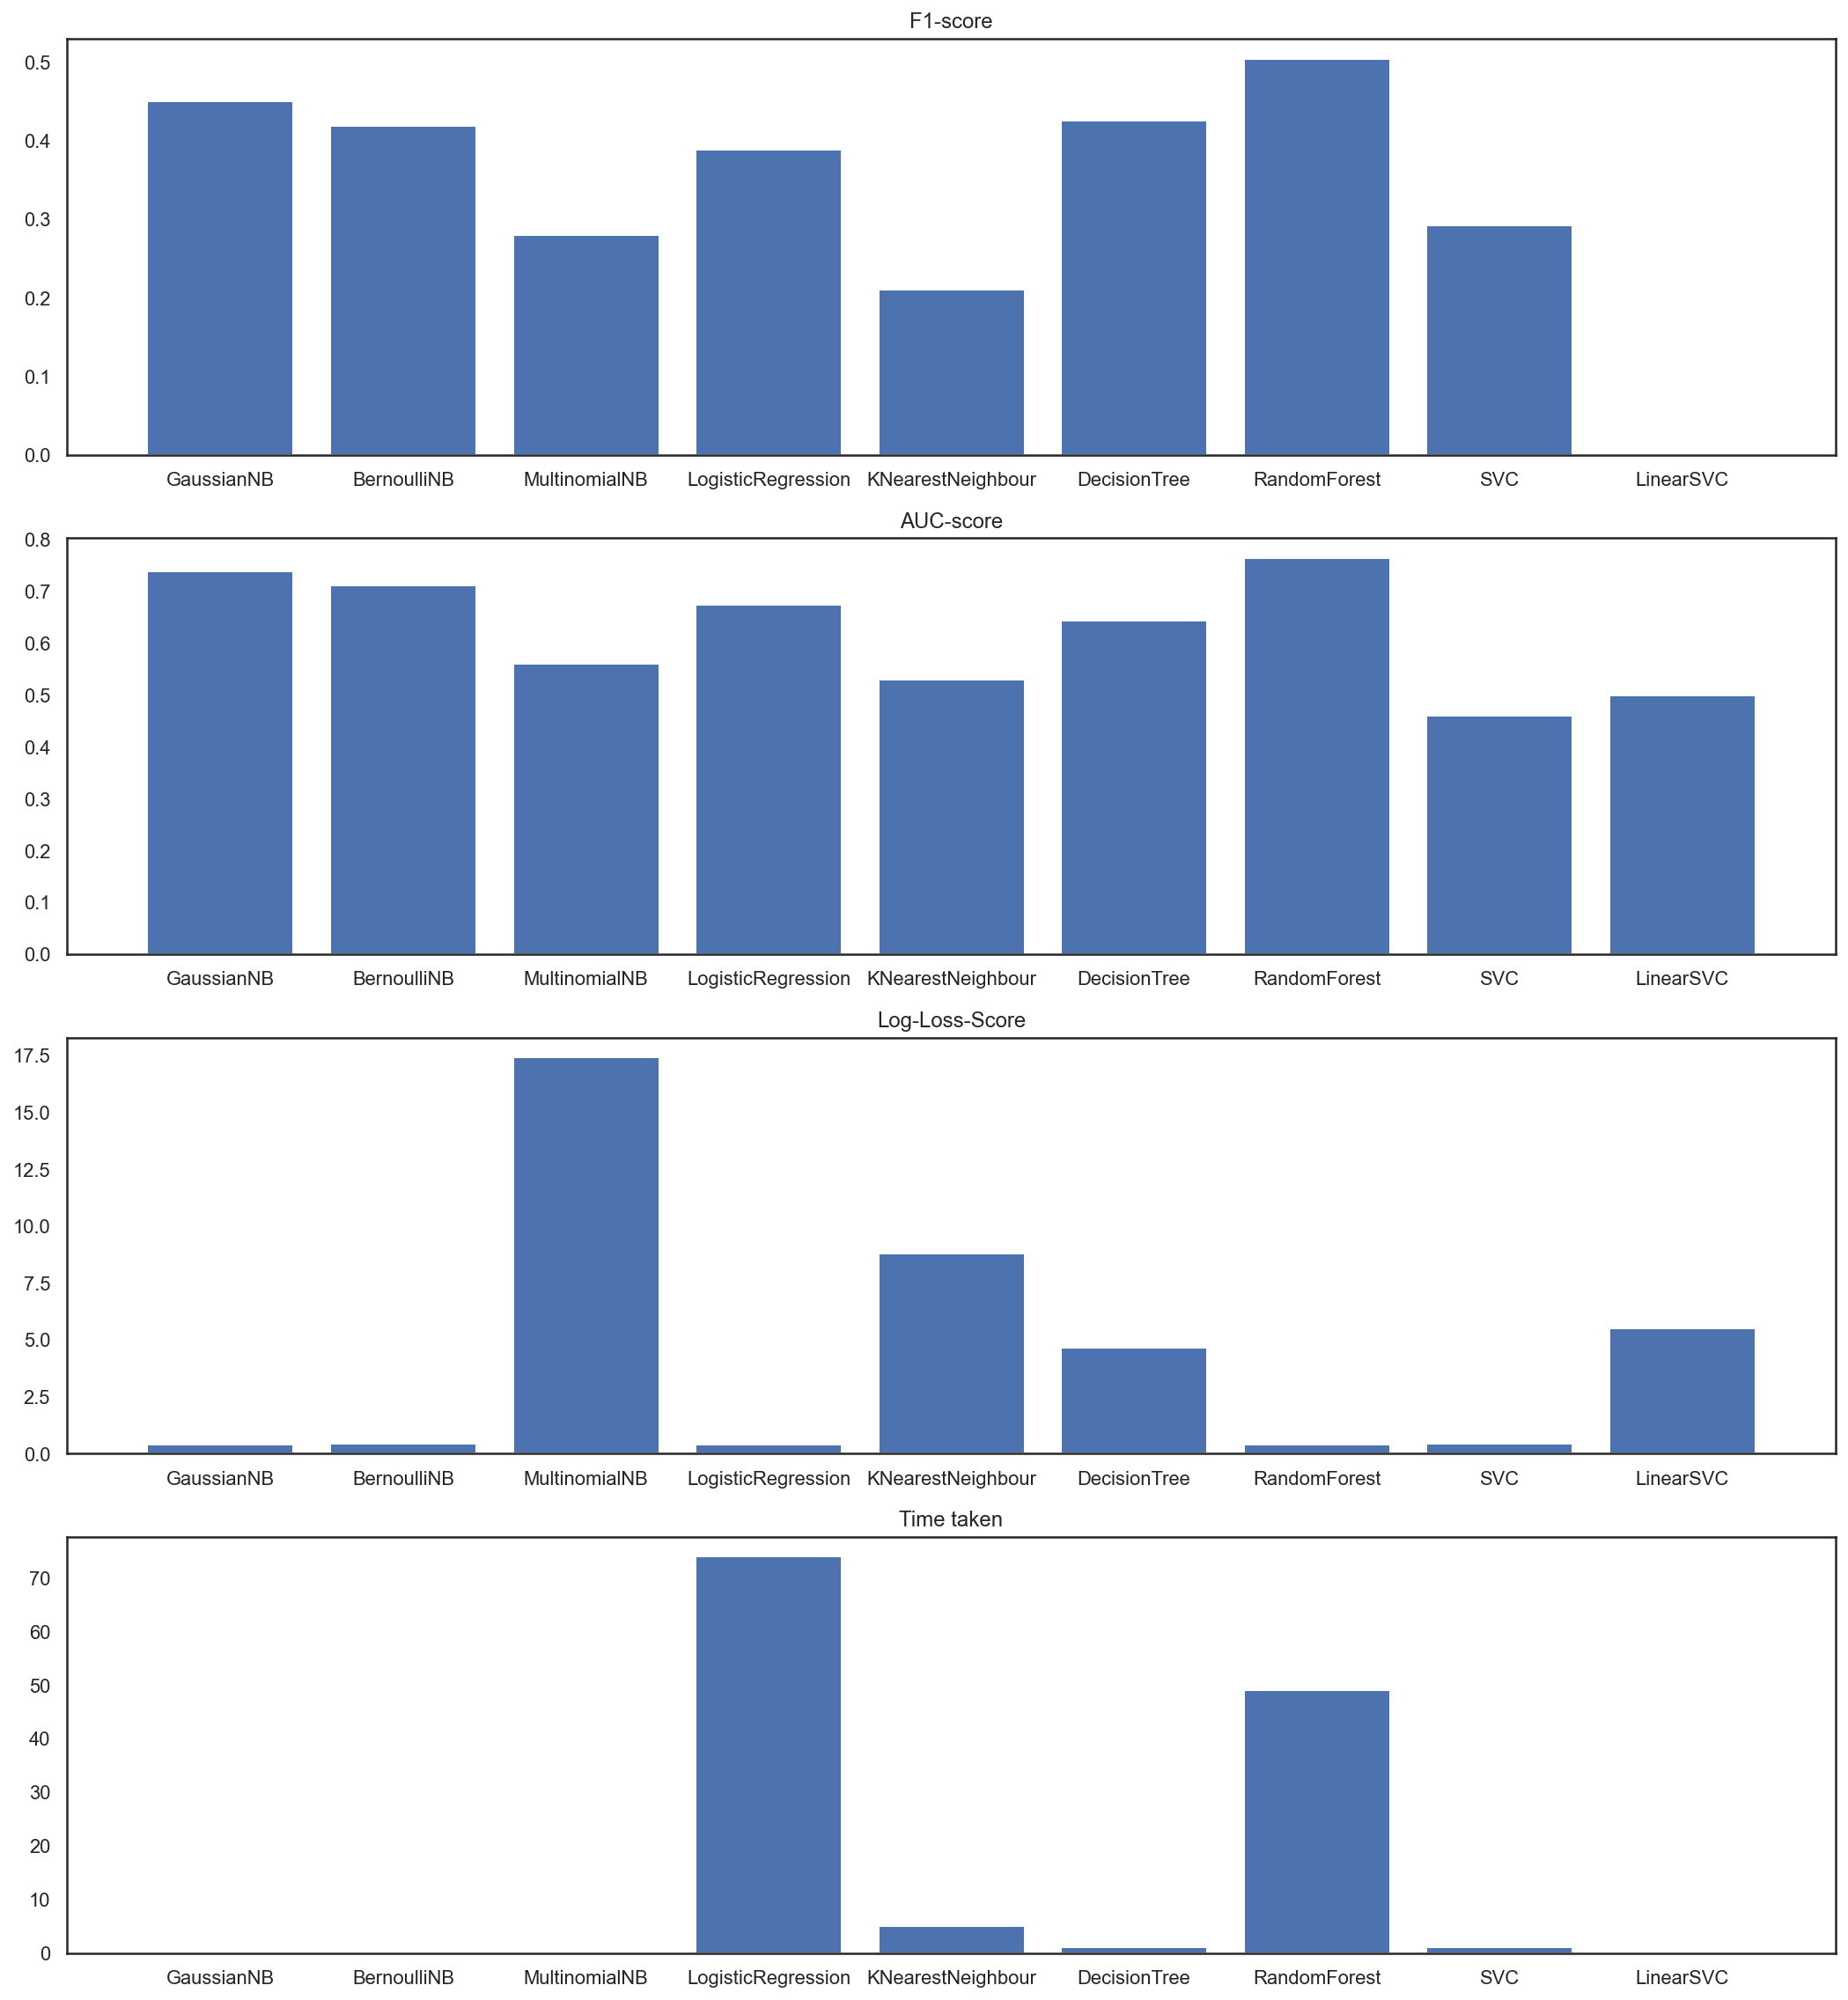

In [29]:
## plot the performance metric scores
fig, ax = plt.subplots(4, 1, figsize=(18, 20))

ax[0].bar(tuned.model, tuned.f1score)
ax[0].set_title('F1-score')

ax[1].bar(tuned.model, tuned.rocauc)
ax[1].set_title('AUC-score')

ax[2].bar(tuned.model, tuned.logloss)
ax[2].set_title('Log-Loss-Score')

ax[3].bar(tuned.model, tuned.timetaken)
ax[3].set_title('Time taken')

# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)

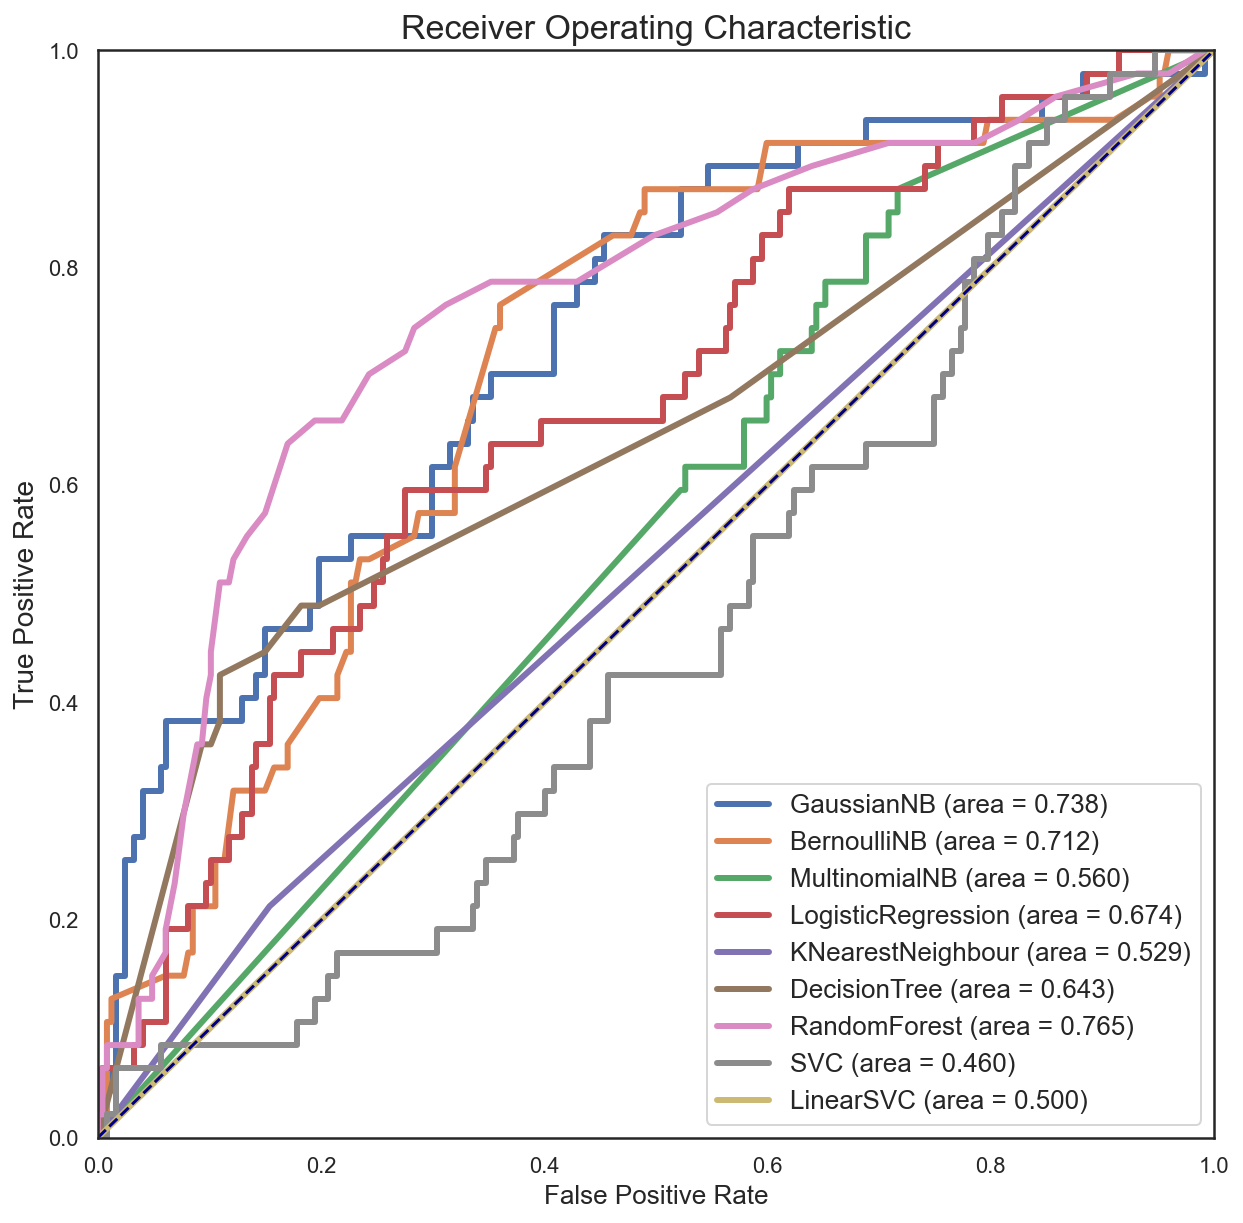

In [30]:
# plot the ROC curves
plt.figure(figsize=(10,10))

# model_name = [gnb, bnb, mnb, logr, knn, dt, rf, xgb, svc, lsvc]
model_name = [gnb, bnb, mnb, logr, knn, dt, rf, svc, lsvc]

for i in range(len(model_name)-1):
    y_pred = model_name[i].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, lw=3, label=tuned.model[i] + ' (area = %0.3f)' % auc(fpr, tpr))

y_pred = lsvc.predict(X_test)   # linearsvc has no attribute 'predict_proba'
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=3, label='LinearSVC (area = %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [31]:
# see how model confusion matrix varies with threshold
bestmodel = rf

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (bestmodel.predict(X_test) is done automatically with a threshold of 0.5)
    y_pred = (bestmodel.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no attrition', 'attrition'],
           yticklabels=['no attrition', 'attrition']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
# Let's see how the confusion matrix changes with changes to the threshold 
from ipywidgets import interactive, FloatSlider
# bestmodel = LogisticRegression(C = optimal_c)
# bestmodel.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(bestmodel, threshold), threshold=(0.0,1.0,0.01))


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…